# Example: Choice under Risk and Ambiguity Task (Levy et al., 2010)

In [1]:
# Load dependencies
from datetime import datetime
import numpy as np
from scipy.stats import bernoulli
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
# Load implementations of ADO on Psi functions
from adopy.tasks.cra import TaskCRA, ModelLinear, EngineCRA

In [3]:
def make_fixed_designs():
    # Define grids for the probability for rewarding and the ambiguity level
    ## For risky conditions
    pr_risky = np.array([.13, .25, .38])
    am_risky = np.array([.0])

    ## For ambiguous conditions
    pr_ambig = np.array([.5])
    am_ambig = np.array([.25, .50, .75])

    ## Make cartesian products for each condition
    pr_am_risky = np.squeeze(np.stack(np.meshgrid(pr_risky, am_risky), -1))
    pr_am_ambig = np.squeeze(np.stack(np.meshgrid(pr_ambig, am_ambig), -1))

    ## Merge two grids into one object
    pr_am = np.vstack([pr_am_risky, pr_am_ambig])

    rv = np.array([5, 9.5, 18, 34, 65])
    rf = np.array([5])

    rws = np.vstack([(v, f) for v in rv for f in rf])

    designs = np.array([
        np.concatenate([pr_am[i], rws[j], [k]]) for i in range(len(pr_am))
        for j in range(len(rws)) for k in range(2)
    ])
    np.random.shuffle(designs)
    designs[:, 3] += np.random.randint(-1, 2, len(designs)) * .1
    designs[:, 4] += np.random.randint(-1, 2, len(designs)) * .1

    return pd.DataFrame(
        designs[:, :4], columns=['prob', 'ambig', 'r_var', 'r_fix'])

In [4]:
def make_grid_designs(size=11):
    # For risky conditions
    pr_risky = np.linspace(0.0, 0.5, size)[1:]
    am_risky = np.array(0).reshape(-1)

    # For ambiguous conditions
    pr_ambig = np.array(0.5).reshape(-1)
    am_ambig = np.linspace(0.0, 0.8, size)[1:]

    # Make cartesian products for each condition
    pr_am_risky = np.squeeze(np.stack(np.meshgrid(pr_risky, am_risky), -1))
    pr_am_ambig = np.squeeze(np.stack(np.meshgrid(pr_ambig, am_ambig), -1))

    # Merge two grids into one object
    pr_am = np.vstack([pr_am_risky, pr_am_ambig])

    # Define grids for rewards on each option
    r_var = np.round(np.logspace(np.log10(10), np.log10(250), size, base=10))
    r_fix = np.round(np.logspace(np.log10(10), np.log10(125), size, base=10))

    rs = np.vstack([(rv, rf) for rv in r_var for rf in r_fix if rv > rf * 2])

    return {('prob', 'ambig'): pr_am, ('r_var', 'r_fix'): rs}

In [5]:
def make_grid_params(size=11):
    # Define grids for other parameters
    alp = np.linspace(0.0, 2.0, size)
    bet = np.linspace(-1.0, 1.0, size)
    gam = np.linspace(0.0, 5.0, size)

    return {'alpha': alp, 'beta': bet, 'gamma': gam}

In [6]:
# Simultation settings
NUM_TRIAL = 60
ALP_TRUE = 0.7
BET_TRUE = .40
GAM_TRUE = .50
GRID_SIZE = 11

In [7]:
task = TaskCRA()
model = ModelLinear()
designs_fixed = make_fixed_designs()

engines = {
    'optimal': EngineCRA(model, make_grid_designs(GRID_SIZE), make_grid_params(GRID_SIZE)),
    'fixed': EngineCRA(model, make_grid_designs(GRID_SIZE), make_grid_params(GRID_SIZE)),
    'random': EngineCRA(model, make_grid_designs(GRID_SIZE), make_grid_params(GRID_SIZE))
}

In [8]:
designs = {k: [] for k in engines.keys()}
post_means = {k: [] for k in engines.keys()}
post_sigmas = {k: [] for k in engines.keys()}
ts_elapsed = {k: [] for k in engines.keys()}

In [9]:
for design_type, engine in engines.items():
    for trial in range(1, NUM_TRIAL + 1):
        d = engine.get_design('optimal')

        # Get a response & update posterior
        p_obs = ModelLinear().compute(
            prob=d['prob'],
            ambig=d['ambig'],
            r_var=d['r_var'],
            r_fix=d['r_fix'],
            alpha=ALP_TRUE,
            beta=BET_TRUE,
            gamma=GAM_TRUE)
        y_obs = bernoulli.rvs(p_obs)
        engine.update(d, y_obs)

        post_mean = engine.post_mean
        post_sd = engine.post_sd

        t_stop = datetime.now()
        t_elapsed = np.float((t_stop - t_start).total_seconds())
        
        designs[design_type].append(pd.DataFrame([[trial, *d]], columns=['trial', *task.design], index=[trial]))
        post_means[design_type].append(pd.DataFrame([engine.post_mean], columns=model.param, index=[trial]))
        post_sigmas[design_type].append(pd.DataFrame([engine.post_sd], columns=model.param, index=[trial]))
        ts_elapsed[design_type].append(t_elapsed)
    
    designs[design_type] = pd.concat(designs[design_type])
    post_means[design_type] = pd.concat(post_means[design_type])
    post_sigmas[design_type] = pd.concat(post_sigmas[design_type])
    ts_elapsed[design_type] = np.array(ts_elapsed[design_type])

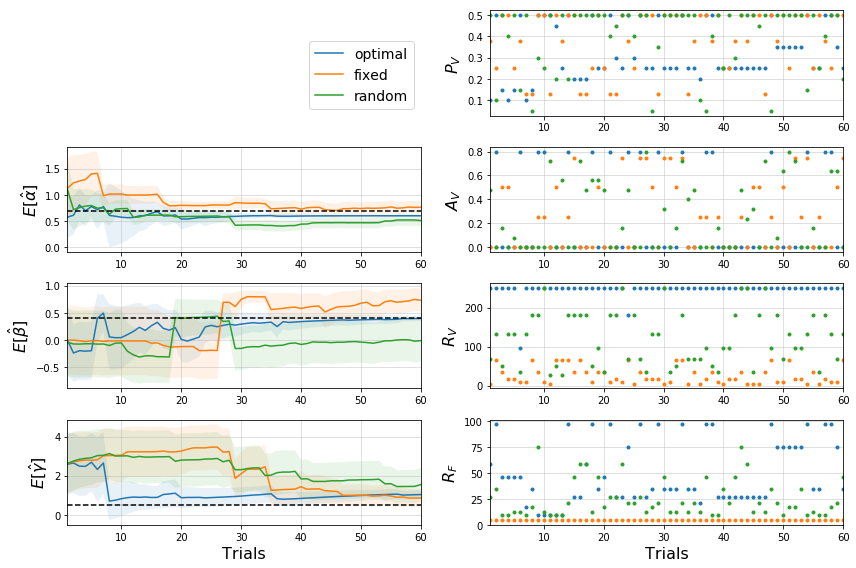

In [10]:
fig, ax = plt.subplots(4, 2)
fig.set_size_inches(12, 8)

legends = {}

for m in engines.keys():
    for i, key in enumerate(post_means[m]):
        _l, = ax[i + 1, 0].plot(post_means[m].index.values, post_means[m][key].values)
        legends[m] = _l
        ax[i + 1, 0].fill_between(post_means[m].index.values,
                                  post_means[m][key].values - post_sigmas[m][key].values,
                                  post_means[m][key].values + post_sigmas[m][key].values,
                                  alpha=0.1)

    for i, k in enumerate(task.design):
        ax[i, 1].plot(designs[m]['trial'].values, designs[m][k].values, '.')

pars_true = [ALP_TRUE, BET_TRUE, GAM_TRUE]
for i, ylabel_l in enumerate([r'$E[\hat{\alpha}]$', r'$E[\hat{\beta}]$', r'$E[\hat{\gamma}]$']):
    ax[i + 1, 0].set_ylabel(ylabel_l, fontsize=16)
    ax[i + 1, 0].axhline(pars_true[i], color='black', linestyle='--', label='True parameters')
    ax[i + 1, 0].grid(alpha=.5)
    ax[i + 1, 0].set_xlim(1, 60)

for i, ylabel_r in enumerate([r'$P_V$', r'$A_V$', r'$R_V$', r'$R_F$']):
    ax[i, 1].set_ylabel(ylabel_r, fontsize=16)
    ax[i, 1].grid(alpha=.5)
    ax[i, 1].set_xlim(1, 60)

ax[0, 0].axis('off')
ax[0, 0].legend(list(legends.values()), list(engines.keys()), loc='lower right', fontsize=14)
ax[3, 0].set_xlabel('Trials', fontsize=16)
ax[3, 1].set_xlabel('Trials', fontsize=16)

plt.tight_layout()
#plt.savefig('images/cra-summary.png')
plt.show()

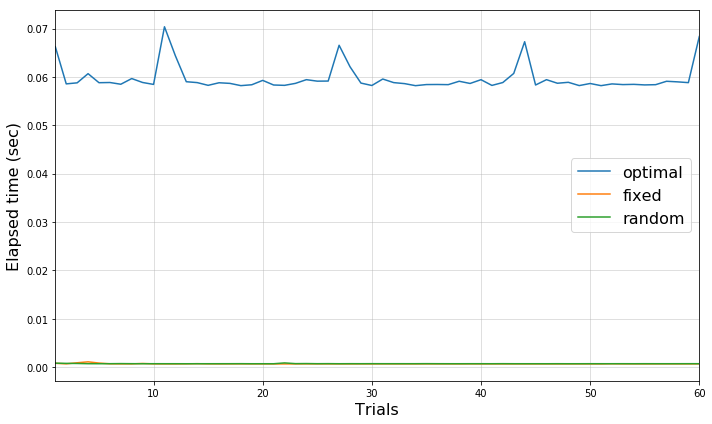

In [11]:
dat_ts = pd.DataFrame(ts_elapsed)
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
ax.plot(np.arange(1, 61), dat_ts)
ax.set_xlabel('Trials', fontsize=16)
ax.set_ylabel('Elapsed time (sec)', fontsize=16)
ax.legend(dat_ts.columns, fontsize=16)
ax.set_xlim(1, 60)
ax.grid(alpha=.5)
plt.tight_layout()
#plt.savefig('images/cra-elapsed-time.png')
plt.show()